<a href="https://colab.research.google.com/github/KartikayBhardwaj-dev/Deep_learning_college/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Machine Translation with Sequence-to-Sequence Models and Attention Mechanism**

**Course:** Deep Learning and Generative AI  
**Institution:** IIT Madras  
**Author:** Prof. Balaji Srinivasan  
**Date:** November, 2025  

---

## **Learning Objectives**

By the end of this tutorial, students will be able to:

1. **Understand** the architecture and principles of sequence-to-sequence (Seq2Seq) models for neural machine translation
2. **Implement** encoder-decoder architectures with attention mechanisms using PyTorch
3. **Apply** bidirectional RNNs and GRU cells for effective sequence processing
4. **Build** custom vocabulary classes for tokenization and numericalization
5. **Train** and evaluate neural translation models using teacher forcing and BLEU metrics
6. **Visualize** attention weights to interpret model behavior and translation quality

---

## **Prerequisites**

- Familiarity with PyTorch fundamentals and recurrent neural networks (RNNs)
- Understanding of encoder-decoder architectures and sequence modeling
- Knowledge of natural language processing concepts (tokenization, vocabulary building)
- Basic understanding of machine translation evaluation metrics
- Experience with PyTorch DataLoaders and training loops

## **1. Overview and Theoretical Framework**

### **1.1 Introduction to Neural Machine Translation**

**Neural Machine Translation (NMT)** represents a paradigm shift from traditional statistical approaches to deep learning-based translation systems. This tutorial demonstrates the implementation of a **sequence-to-sequence (Seq2Seq) model with attention mechanism** for translating German text to English.

### **1.2 Architecture Components**

The complete NMT system consists of the following key components:

| **Component** | **Function** | **Implementation** |
|---------------|--------------|-------------------|
| **Encoder** | Processes source language sequence into context vectors | Bidirectional GRU with embeddings |
| **Attention Mechanism** | Dynamically focuses on relevant source tokens during decoding | Bahdanau attention with learned alignment |
| **Decoder** | Generates target language sequence using encoder outputs | Unidirectional GRU with attention-weighted context |
| **Vocabulary Builder** | Maps tokens to numerical indices for neural processing | Custom Vocab class with special tokens |

### **1.3 Mathematical Framework**

The encoder-decoder architecture with attention can be formalized as:

**Encoder:** h₁, h₂, ..., hₜ = BiGRU(x₁, x₂, ..., xₜ)

**Attention:** αᵢⱼ = softmax(score(sⱼ₋₁, hᵢ))

**Context:** cⱼ = Σᵢ αᵢⱼ · hᵢ

**Decoder:** sⱼ = GRU(yⱼ₋₁, cⱼ, sⱼ₋₁)

Where:
- **x**: Source sequence tokens
- **y**: Target sequence tokens
- **h**: Encoder hidden states
- **s**: Decoder hidden states
- **c**: Context vector from attention
- **α**: Attention weights

## **2. Environment Setup and Dependencies**

### **2.1 Installing Required Packages**

The following packages are required for this implementation:
- **evaluate**: For computing BLEU scores and other translation metrics
- **spacy**: For tokenization of source and target languages
- **datasets**: For loading the Multi30k translation dataset
- **torch**: PyTorch deep learning framework

In [ ]:
# Install the evaluate package for computing translation metrics (BLEU score)
# This package provides standardized implementations of NLP evaluation metrics
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Download German language model for spaCy tokenization
# This provides linguistic features for processing German text
#https://spacy.io/models/de
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 63.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### **2.2 Importing Libraries and Modules**

Import essential libraries for deep learning, NLP processing, and data handling.

In [ ]:
# Import core PyTorch libraries for deep learning
import torch
import torch.nn as nn  # Neural network modules and loss functions
import torch.optim as optim  # Optimization algorithms (Adam, SGD, etc.)

# Import standard Python libraries for numerical operations and randomization
import random
import numpy as np

# Import NLP and dataset libraries
from datasets import load_dataset  # HuggingFace datasets for Multi30k
import spacy  # Industrial-strength NLP for tokenization

# Import utilities for progress tracking and evaluation
import tqdm  # Progress bars for training loops
import evaluate  # Standardized NLP metrics (BLEU score)

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Import data structures for vocabulary building
from collections import Counter, OrderedDict

# Display PyTorch version and device information
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4


### **2.3 Reproducibility: Setting Random Seeds**

**Reproducibility is essential for scientific research and debugging.** Setting random seeds ensures that experiments produce consistent results across different runs, facilitating:

1. **Debugging**: Consistent behavior makes it easier to identify and fix issues
2. **Comparison**: Fair evaluation of different model architectures and hyperparameters
3. **Collaboration**: Other researchers can reproduce experimental results

In [ ]:
# Set random seeds for reproducibility across all random number generators
# This ensures consistent results across different runs of the experiment
seed = 42

# Set seed for Python's built-in random module
random.seed(seed)

# Set seed for NumPy's random number generator
np.random.seed(seed)

# Set seed for PyTorch CPU operations
torch.manual_seed(seed)

# Set seed for PyTorch CUDA operations (GPU)
torch.cuda.manual_seed(seed)

# Enable deterministic behavior for CUDA operations
# Note: This may impact performance but ensures reproducibility
torch.backends.cudnn.deterministic = True

print(f"Random seeds set to {seed} for reproducible experiments")

Random seeds set to 42 for reproducible experiments


## **3. Data Preparation and Preprocessing**

### **3.1 Loading the Multi30k Dataset**

**The Multi30k dataset** is a multilingual image caption dataset containing approximately 31,000 German-English sentence pairs. This dataset is widely used for:

- **Machine translation research**: Evaluating NMT systems
- **Multimodal learning**: Connecting vision and language
- **Low-resource translation**: Studying models with limited training data

**Dataset Statistics:**
- Training samples: ~29,000 pairs
- Validation samples: ~1,000 pairs  
- Test samples: ~1,000 pairs
- Average sentence length: 10-15 tokens

In [ ]:
# Load the Multi30k dataset from HuggingFace datasets
# This dataset contains German-English parallel translations
dataset = load_dataset("bentrevett/multi30k")

# Display dataset structure and statistics
print(f"Dataset loaded successfully!")
print(f"Dataset splits: {dataset.keys()}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"\nSample data point:")
print(f"German: {dataset['train'][0]['de']}")
print(f"English: {dataset['train'][0]['en']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Dataset splits: dict_keys(['train', 'validation', 'test'])
Training samples: 29000
Validation samples: 1014
Test samples: 1000

Sample data point:
German: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
English: Two young, White males are outside near many bushes.


In [ ]:
# Partition the dataset into training, validation, and test sets
# This separation enables proper model development and unbiased evaluation
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

print(f"Dataset partitioning complete:")
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(valid_data)} samples")
print(f"Test set: {len(test_data)} samples")

Dataset partitioning complete:
Training set: 29000 samples
Validation set: 1014 samples
Test set: 1000 samples


### **3.2 Loading Language Models for Tokenization**

**Tokenization** is the process of splitting text into individual units (tokens) for neural processing. We use **spaCy**, an industrial-strength NLP library, to perform linguistic tokenization that respects word boundaries and handles special cases.

**Why spaCy?**
- Language-aware tokenization (handles contractions, compounds, etc.)
- Pre-trained models with linguistic features
- Efficient processing for large-scale datasets

In [ ]:
# Load pre-trained spaCy language models for English and German
# These models provide tokenization, linguistic features, and NLP capabilities
en_nlp = spacy.load("en_core_web_sm")  # English small model
de_nlp = spacy.load("de_core_news_sm")  # German small model

print(f"Language models loaded successfully:")
print(f"English model: {en_nlp.meta['name']} (v{en_nlp.meta['version']})")
print(f"German model: {de_nlp.meta['name']} (v{de_nlp.meta['version']})")

# Demonstrate tokenization
sample_en = "A man is riding a bicycle."
sample_de = "Ein Mann fährt Fahrrad."
print(f"\nTokenization examples:")
print(f"English: '{sample_en}' -> {[token.text for token in en_nlp.tokenizer(sample_en)]}")
print(f"German: '{sample_de}' -> {[token.text for token in de_nlp.tokenizer(sample_de)]}")

Language models loaded successfully:
English model: core_web_sm (v3.8.0)
German model: core_news_sm (v3.8.0)

Tokenization examples:
English: 'A man is riding a bicycle.' -> ['A', 'man', 'is', 'riding', 'a', 'bicycle', '.']
German: 'Ein Mann fährt Fahrrad.' -> ['Ein', 'Mann', 'fährt', 'Fahrrad', '.']


### **3.3 Building Custom Vocabulary Class**

**A vocabulary maps tokens (words) to numerical indices** for neural network processing. Our custom `Vocab` class replaces the deprecated `torchtext.vocab` and provides:

1. **Frequency-based filtering**: Remove rare words below minimum frequency threshold
2. **Special tokens**: Handle padding, unknown words, start/end of sequence markers
3. **Bidirectional mapping**: Convert tokens ↔ indices efficiently
4. **Default index handling**: Map unknown words to a designated UNK token

**Special Tokens:**
- `<unk>`: Unknown words not in vocabulary
- `<pad>`: Padding for variable-length sequences
- `<sos>`: Start of sequence marker
- `<eos>`: End of sequence marker

In [ ]:
# Custom Vocabulary class to replace deprecated torchtext.vocab
# This class provides token-to-index mapping with frequency filtering and special tokens
class Vocab:
    """
    Custom vocabulary class for NLP tasks.

    This class builds a vocabulary from tokenized text, filtering by minimum frequency
    and supporting special tokens (UNK, PAD, SOS, EOS). It provides bidirectional
    mapping between tokens and numerical indices for neural network processing.

    Parameters:
    -----------
    tokens : list of list of str
        List of tokenized sequences for building vocabulary
    min_freq : int, default=1
        Minimum frequency threshold for including tokens in vocabulary
    specials : list of str, optional
        Special tokens to add at the beginning of vocabulary (e.g., <unk>, <pad>)

    Attributes:
    -----------
    itos : list
        Index-to-string mapping (list of tokens)
    stoi : dict
        String-to-index mapping (token -> index)
    default_index : int
        Default index for unknown tokens (typically UNK token index)
    """
    def __init__(self, tokens, min_freq=1, specials=None):
        self.specials = specials if specials else []
        self.min_freq = min_freq

        # Count token frequencies across all sequences
        counter = Counter()
        for token_list in tokens:
            counter.update(token_list)

        # Build vocabulary: special tokens first, then frequent tokens
        self.itos = self.specials.copy()
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        # Create reverse mapping (token -> index)
        self.stoi = {token: idx for idx, token in enumerate(self.itos)}
        self.default_index = None

    def __len__(self):
        """Return vocabulary size."""
        return len(self.itos)

    def __getitem__(self, token):
        """Look up index for a given token (returns default_index if not found)."""
        return self.stoi.get(token, self.default_index if self.default_index is not None else 0)

    def set_default_index(self, index):
        """Set default index for unknown tokens (usually UNK token index)."""
        self.default_index = index

    def lookup_indices(self, tokens):
        """Convert list of tokens to list of indices."""
        return [self[token] for token in tokens]

    def lookup_tokens(self, indices):
        """Convert list of indices to list of tokens."""
        return [self.itos[idx] for idx in indices]

### **3.4 Tokenization Function**

The tokenization function processes raw text into token sequences with the following steps:

1. **Apply spaCy tokenizer**: Split text into linguistic tokens
2. **Length limiting**: Truncate sequences exceeding maximum length
3. **Case normalization**: Convert to lowercase (optional, controlled by parameter)
4. **Add special tokens**: Prepend `<sos>` and append `<eos>` markers

These preprocessing steps ensure uniform input format for the neural model.

In [ ]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    """
    Tokenize a translation example (German-English pair) using spaCy.

    This function processes both source and target sentences by:
    1. Applying language-specific tokenization
    2. Truncating to maximum length
    3. Optionally converting to lowercase
    4. Adding start-of-sequence and end-of-sequence markers

    Parameters:
    -----------
    example : dict
        Dictionary containing 'de' and 'en' keys with German and English text
    en_nlp : spacy.Language
        English spaCy language model
    de_nlp : spacy.Language
        German spaCy language model
    max_length : int
        Maximum sequence length (tokens beyond this are truncated)
    lower : bool
        Whether to convert tokens to lowercase
    sos_token : str
        Start-of-sequence token (e.g., '<sos>')
    eos_token : str
        End-of-sequence token (e.g., '<eos>')

    Returns:
    --------
    dict
        Dictionary with 'en_tokens' and 'de_tokens' keys containing tokenized sequences
    """
    # Apply spaCy tokenization and truncate to maximum length
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]

    # Convert to lowercase if specified
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]

    # Add sequence boundary markers
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]

    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [ ]:
# Configure tokenization parameters
max_length = 1000  # Maximum tokens per sequence (effectively no limit for Multi30k)
lower = True       # Convert all text to lowercase for vocabulary reduction
sos_token = "<sos>"  # Start-of-sequence marker
eos_token = "<eos>"  # End-of-sequence marker

# Prepare function arguments for dataset mapping
fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

# Apply tokenization to all dataset splits
# The map() function applies tokenize_example to each sample
train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

print(f"Tokenization complete!")
print(f"Sample tokenized data:")
print(f"German tokens: {train_data[0]['de_tokens'][:10]}...")
print(f"English tokens: {train_data[0]['en_tokens'][:10]}...")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization complete!
Sample tokenized data:
German tokens: ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der']...
English tokens: ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many']...


### **3.5 Building Vocabularies from Training Data**

**Vocabulary construction is performed exclusively on the training set** to prevent data leakage. Key considerations:

- **Minimum frequency threshold**: Remove rare words to reduce vocabulary size and improve generalization
- **Special tokens**: Include markers for unknown words, padding, and sequence boundaries
- **Training-only**: Validation and test vocabularies use the same mapping built from training data

This approach ensures that the model learns from training distribution and generalizes to unseen vocabulary patterns.

In [ ]:
# Define vocabulary parameters
min_freq = 2  # Minimum token frequency to be included in vocabulary (reduces vocabulary size)
unk_token = "<unk>"  # Unknown token for words not in vocabulary
pad_token = "<pad>"  # Padding token for batch processing of variable-length sequences

# Define all special tokens in priority order
# These tokens are added to vocabulary first to ensure consistent indices across languages
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

# Build English vocabulary from training data tokens
en_vocab = Vocab(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

# Build German vocabulary from training data tokens
de_vocab = Vocab(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

# Display vocabulary statistics
print(f"Vocabulary Statistics:")
print(f"English vocabulary size: {len(en_vocab):,}")
print(f"German vocabulary size: {len(de_vocab):,}")
print(f"Minimum frequency threshold: {min_freq}")
print(f"\nSpecial token indices:")
print(f"  <unk>: {en_vocab[unk_token]}")
print(f"  <pad>: {en_vocab[pad_token]}")
print(f"  <sos>: {en_vocab[sos_token]}")
print(f"  <eos>: {en_vocab[eos_token]}")

Vocabulary Statistics:
English vocabulary size: 5,893
German vocabulary size: 7,853
Minimum frequency threshold: 2

Special token indices:
  <unk>: 0
  <pad>: 1
  <sos>: 2
  <eos>: 3


In [ ]:
# Verify that special tokens have consistent indices across both vocabularies
# This is crucial for correct model behavior with padding and unknown tokens
assert en_vocab[unk_token] == de_vocab[unk_token], "UNK token indices must match"
assert en_vocab[pad_token] == de_vocab[pad_token], "PAD token indices must match"

# Store special token indices for later use
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(f"Special token verification passed!")
print(f"UNK index: {unk_index}")
print(f"PAD index: {pad_index}")

Special token verification passed!
UNK index: 0
PAD index: 1


In [ ]:
# Configure vocabularies to return UNK index for out-of-vocabulary tokens
# This ensures unknown words are mapped to <unk> instead of causing errors
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

print(f"Default indices set to UNK token ({unk_index})")
print(f"Unknown words will be mapped to: '{unk_token}'")

Default indices set to UNK token (0)
Unknown words will be mapped to: '<unk>'


### **3.6 Numericalization: Converting Tokens to Indices**

**Numericalization transforms token sequences into integer indices** suitable for embedding layers. This process:

1. **Maps each token to its vocabulary index**: Uses the bidirectional mapping from Vocab class
2. **Handles unknown tokens**: Automatically maps OOV words to UNK index
3. **Preserves sequence structure**: Maintains order and special token positions

In [ ]:
def numericalize_example(example, en_vocab, de_vocab):
    """
    Convert tokenized sequences to numerical indices using vocabularies.

    Parameters:
    -----------
    example : dict
        Dictionary containing 'en_tokens' and 'de_tokens' keys
    en_vocab : Vocab
        English vocabulary for index lookup
    de_vocab : Vocab
        German vocabulary for index lookup

    Returns:
    --------
    dict
        Dictionary with 'en_ids' and 'de_ids' keys containing numerical sequences
    """
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [ ]:
# Apply numericalization to all dataset splits
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

print(f"Numericalization complete!")
print(f"Sample numericalized data:")
print(f"German indices: {train_data[0]['de_ids'][:10]}...")
print(f"English indices: {train_data[0]['en_ids'][:10]}...")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Numericalization complete!
Sample numericalized data:
German indices: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]...
English indices: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]...


### **3.7 Data Format Configuration for PyTorch**

Configure the dataset to return PyTorch tensors for efficient batch processing.

In [ ]:
# Configure dataset to return PyTorch tensors instead of Python lists
# This enables efficient batching and GPU acceleration
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

print(f"Dataset format configured for PyTorch tensors")
print(f"Formatted columns: {format_columns}")

Dataset format configured for PyTorch tensors
Formatted columns: ['en_ids', 'de_ids']


### **3.8 Creating DataLoaders with Dynamic Padding**

**DataLoaders enable efficient batch processing** with the following capabilities:

1. **Dynamic padding**: Pad sequences to match the longest sequence in each batch
2. **Batching**: Group samples for parallel processing
3. **Shuffling**: Randomize training data to prevent order bias
4. **Memory efficiency**: Load data on-demand rather than storing all in memory

In [ ]:
def get_collate_fn(pad_index):
    """
    Create a collate function for batching variable-length sequences.

    This function pads sequences in a batch to the same length, enabling
    efficient matrix operations on GPU. Padding is applied to the maximum
    sequence length within each batch (dynamic padding).

    Parameters:
    -----------
    pad_index : int
        Index of the padding token in vocabulary

    Returns:
    --------
    function
        Collate function that batches and pads sequences
    """
    def collate_fn(batch):
        # Extract German and English sequences from batch
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = [example["en_ids"] for example in batch]

        # Pad sequences to maximum length in batch
        # Result shape: [max_seq_len, batch_size]
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)

        batch = {
            "de_ids": batch_de_ids,
            "en_ids": batch_en_ids,
        }
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    """
    Create a DataLoader for batch processing with custom collation.

    Parameters:
    -----------
    dataset : Dataset
        HuggingFace dataset containing translation pairs
    batch_size : int
        Number of samples per batch
    pad_index : int
        Padding token index for sequence alignment
    shuffle : bool, default=False
        Whether to shuffle data (typically True for training)

    Returns:
    --------
    DataLoader
        PyTorch DataLoader with custom collate function
    """
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
# Configure batch size for training
# Larger batches improve GPU utilization but require more memory
batch_size = 256

# Create DataLoaders for all dataset splits
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

print(f"DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_data_loader)}")
print(f"Validation batches: {len(valid_data_loader)}")
print(f"Test batches: {len(test_data_loader)}")

DataLoaders created successfully!
Batch size: 256
Training batches: 114
Validation batches: 4
Test batches: 4


## **4. Model Architecture Implementation**

### **4.1 Encoder Architecture**

The **encoder processes the source language sequence** (German) and produces context-rich representations:

**Key Components:**
- **Embedding Layer**: Maps token indices to dense vectors
- **Bidirectional GRU**: Captures both forward and backward context
- **Linear Transformation**: Projects bidirectional hidden states to decoder dimension
- **Dropout**: Regularization to prevent overfitting

**Architecture Flow:**
```
Input indices → Embedding → Dropout → Bidirectional GRU → Linear → Tanh
```

In [ ]:
class Encoder(nn.Module):
    """
    Bidirectional GRU encoder for sequence-to-sequence translation.

    The encoder processes the source language sequence and produces:
    1. Encoder outputs: All hidden states from both directions
    2. Final hidden state: Context vector for initializing decoder

    Architecture:
    - Embedding layer for token representation
    - Bidirectional GRU for capturing forward/backward context
    - Linear layer to project to decoder hidden dimension

    Parameters:
    -----------
    input_dim : int
        Size of source vocabulary
    embedding_dim : int
        Dimension of token embeddings
    encoder_hidden_dim : int
        Hidden dimension of encoder GRU (per direction)
    decoder_hidden_dim : int
        Hidden dimension of decoder (for projection)
    dropout : float
        Dropout probability for regularization
    """
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        # Token embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Bidirectional GRU (outputs have 2*encoder_hidden_dim dimension)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)

        # Project concatenated bidirectional hidden states to decoder dimension
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        """
        Forward pass through encoder.

        Parameters:
        -----------
        src : torch.Tensor
            Source sequence [src_length, batch_size]

        Returns:
        --------
        outputs : torch.Tensor
            All encoder hidden states [src_length, batch_size, encoder_hidden_dim * 2]
        hidden : torch.Tensor
            Final hidden state for decoder initialization [batch_size, decoder_hidden_dim]
        """
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]

        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer

        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

### **4.2 Attention Mechanism**

**The attention mechanism allows the decoder to focus on relevant parts of the source sequence** at each decoding step. This addresses the bottleneck of compressing the entire source into a fixed-size vector.

**Bahdanau Attention:**
1. **Compute energy scores**: Measure compatibility between decoder state and encoder outputs
2. **Apply softmax**: Normalize scores to attention weights (sum to 1)
3. **Create context vector**: Weighted sum of encoder outputs

**Mathematical Formulation:**
- energy = tanh(W[h; s])
- attention = softmax(V · energy)
- context = Σ(attention · encoder_outputs)

In [ ]:
class Attention(nn.Module):
    """
    Bahdanau attention mechanism for sequence-to-sequence models.

    Computes attention weights that allow the decoder to focus on
    relevant parts of the encoder outputs at each decoding step.

    Parameters:
    -----------
    encoder_hidden_dim : int
        Hidden dimension of encoder (per direction)
    decoder_hidden_dim : int
        Hidden dimension of decoder
    """
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        # Linear layer to compute attention energy
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        # Linear layer to compute attention scores
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        """
        Compute attention weights over encoder outputs.

        Parameters:
        -----------
        hidden : torch.Tensor
            Current decoder hidden state [batch_size, decoder_hidden_dim]
        encoder_outputs : torch.Tensor
            All encoder hidden states [src_length, batch_size, encoder_hidden_dim * 2]

        Returns:
        --------
        attention : torch.Tensor
            Attention weights [batch_size, src_length]
        """
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]

        # Compute attention energy
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]

        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]

        return torch.softmax(attention, dim=1)

### **4.3 Decoder Architecture**

**The decoder generates the target language sequence** token-by-token using:

1. **Attention-weighted context**: Focuses on relevant source tokens
2. **Previous token embedding**: Target language history
3. **Hidden state**: Decoder memory of generation process

**Decoding Process:**
- Concatenate [embedding, context] as GRU input
- Update hidden state with GRU
- Predict next token from [output, context, embedding]

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

### **4.4 Seq2Seq Model: Combining Encoder and Decoder**

The complete **sequence-to-sequence model** orchestrates the encoder-decoder architecture with attention:

1. **Encoding**: Process source sequence through bidirectional encoder
2. **Decoding**: Generate target sequence autoregressively
3. **Teacher Forcing**: Use ground truth tokens during training (with probability)
4. **Inference**: Use model predictions during evaluation

In [ ]:
# Define model hyperparameters
input_dim = len(de_vocab)  # German vocabulary size
output_dim = len(en_vocab)  # English vocabulary size
encoder_embedding_dim = 256  # Dimension of source embeddings
decoder_embedding_dim = 256  # Dimension of target embeddings
encoder_hidden_dim = 512  # Hidden dimension of encoder GRU (per direction)
decoder_hidden_dim = 512  # Hidden dimension of decoder GRU
encoder_dropout = 0.5  # Dropout probability for encoder
decoder_dropout = 0.5  # Dropout probability for decoder

# Determine device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model components
encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout
)

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

# Create complete Seq2Seq model and move to device
model = Seq2Seq(encoder, decoder, device).to(device)

print(f"Model created and moved to device: {device}")
print(f"Input vocabulary size (German): {input_dim:,}")
print(f"Output vocabulary size (English): {output_dim:,}")

Model created and moved to device: cuda
Input vocabulary size (German): 7,853
Output vocabulary size (English): 5,893


## **5. Model Instantiation and Configuration**

### **5.1 Weight Initialization**

**Proper weight initialization is crucial for effective training.** We use **Xavier (Glorot) initialization** for weights and zero initialization for biases, which helps:

1. **Prevent vanishing/exploding gradients**: Maintains signal propagation through layers
2. **Accelerate convergence**: Provides good starting point for optimization
3. **Improve final performance**: Better local minima discovery

In [ ]:
def init_weights(m):
    """
    Initialize model weights using Xavier uniform initialization.

    This function applies appropriate initialization strategies:
    - Xavier (Glorot) uniform for weight matrices
    - Zero initialization for bias vectors

    Parameters:
    -----------
    m : nn.Module
        PyTorch module to initialize
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param)
        else:
            nn.init.constant_(param.data, 0)

# Apply initialization to all model parameters
model.apply(init_weights)

print(f"Model weights initialized using Xavier uniform distribution")

Model weights initialized using Xavier uniform distribution


In [ ]:
def count_parameters(model):
    """
    Count the number of trainable parameters in the model.

    Parameters:
    -----------
    model : nn.Module
        PyTorch model

    Returns:
    --------
    int
        Total number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Display model size
total_params = count_parameters(model)
print(f"The model has {total_params:,} trainable parameters")
print(f"Model size: ~{total_params * 4 / 1024**2:.2f} MB (assuming 32-bit floats)")

The model has 20,518,405 trainable parameters
Model size: ~78.27 MB (assuming 32-bit floats)


In [ ]:
# Initialize Adam optimizer with default hyperparameters
# Adam provides adaptive learning rates and momentum for each parameter
optimizer = optim.Adam(model.parameters())

print(f"Optimizer: Adam")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Optimizer: Adam
Learning rate: 0.001


## **6. Training Setup and Optimization**

### **6.1 Loss Function**

**Cross-Entropy Loss** with padding token masking:
- Measures prediction error for multi-class classification (next token prediction)
- `ignore_index` parameter excludes padding tokens from loss computation
- Prevents model from learning to predict padding tokens

In [ ]:
# Define loss function with padding token masking
# CrossEntropyLoss computes the negative log-likelihood for multi-class classification
# ignore_index ensures padding tokens don't contribute to the loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

print(f"Loss function: CrossEntropyLoss")
print(f"Ignoring padding tokens at index: {pad_index}")

Loss function: CrossEntropyLoss
Ignoring padding tokens at index: 1


### **6.2 Training Function**

The training function implements one epoch of model training with:

1. **Teacher forcing**: Use ground truth tokens (with probability) instead of predictions
2. **Gradient clipping**: Prevent exploding gradients in RNNs
3. **Batch processing**: Iterate through DataLoader batches
4. **Loss computation**: Calculate and backpropagate training loss

In [ ]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

### **6.3 Evaluation Function**

Evaluation without teacher forcing to assess true model performance on validation/test data.

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

  5%|▌         | 1/20 [01:36<30:32, 96.45s/it]

	Train Loss:   5.202 | Train PPL: 181.544
	Valid Loss:   4.931 | Valid PPL: 138.501


 10%|█         | 2/20 [03:11<28:39, 95.53s/it]

	Train Loss:   4.335 | Train PPL:  76.358
	Valid Loss:   4.694 | Valid PPL: 109.243


 15%|█▌        | 3/20 [04:46<26:59, 95.28s/it]

	Train Loss:   3.919 | Train PPL:  50.348
	Valid Loss:   4.418 | Valid PPL:  82.938


 20%|██        | 4/20 [06:23<25:34, 95.93s/it]

	Train Loss:   3.405 | Train PPL:  30.100
	Valid Loss:   4.004 | Valid PPL:  54.842


 25%|██▌       | 5/20 [07:59<23:58, 95.88s/it]

	Train Loss:   2.966 | Train PPL:  19.424
	Valid Loss:   3.659 | Valid PPL:  38.836


 30%|███       | 6/20 [09:34<22:19, 95.67s/it]

	Train Loss:   2.591 | Train PPL:  13.344
	Valid Loss:   3.526 | Valid PPL:  33.976


 35%|███▌      | 7/20 [11:09<20:43, 95.66s/it]

	Train Loss:   2.288 | Train PPL:   9.855
	Valid Loss:   3.445 | Valid PPL:  31.355


 40%|████      | 8/20 [12:45<19:06, 95.55s/it]

	Train Loss:   2.069 | Train PPL:   7.916
	Valid Loss:   3.462 | Valid PPL:  31.869


 45%|████▌     | 9/20 [14:20<17:31, 95.61s/it]

	Train Loss:   1.899 | Train PPL:   6.679
	Valid Loss:   3.462 | Valid PPL:  31.870


 50%|█████     | 10/20 [15:56<15:56, 95.70s/it]

	Train Loss:   1.704 | Train PPL:   5.494
	Valid Loss:   3.491 | Valid PPL:  32.815


 55%|█████▌    | 11/20 [17:32<14:20, 95.65s/it]

	Train Loss:   1.589 | Train PPL:   4.897
	Valid Loss:   3.495 | Valid PPL:  32.965


 60%|██████    | 12/20 [19:07<12:44, 95.51s/it]

	Train Loss:   1.362 | Train PPL:   3.904
	Valid Loss:   3.461 | Valid PPL:  31.849


 65%|██████▌   | 13/20 [20:42<11:06, 95.21s/it]

	Train Loss:   1.303 | Train PPL:   3.680
	Valid Loss:   3.477 | Valid PPL:  32.347


 65%|██████▌   | 13/20 [22:17<12:00, 102.90s/it]

Early stopping at epoch 14


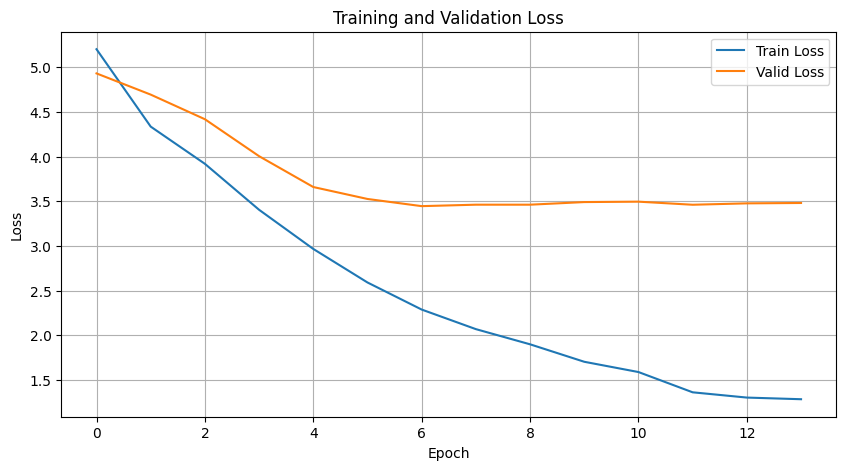

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.6
patience = 7  # Early stopping patience

best_valid_loss = float("inf")

train_losses = []
valid_losses = []

# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Early stopping counter
early_stopping_counter = 0

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Step the scheduler based on validation loss
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "de2en-model.pt")
        early_stopping_counter = 0  # Reset early stopping counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break  # Stop training

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.load_state_dict(torch.load("de2en-model.pt"))


test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.445 | Test PPL:  31.359 |


## **7. Model Evaluation and Testing**

### **7.1 Loading Best Model and Test Evaluation**

Load the saved model checkpoint with best validation performance and evaluate on test set.

In [ ]:
def translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

## **8. Inference and Translation**

### **8.1 Translation Function**

Generate translations for German sentences using greedy decoding:

1. **Encode source sentence**: Process through encoder
2. **Initialize decoder**: Start with `<sos>` token
3. **Autoregressive generation**: Predict tokens one at a time
4. **Stop condition**: Generate until `<eos>` or max length reached
5. **Track attention**: Record attention weights for visualization

In [ ]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

### **8.2 Attention Visualization**

Visualize attention weights to understand which source tokens the model focuses on when generating each target token.

In [ ]:
sentence = train_data[0]["de"]
expected_translation = train_data[0]["en"]

sentence, expected_translation

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

### **8.3 Example Translation**

Demonstrate translation on a sample from the training data.

In [ ]:
translation, sentence_tokens, attention  = translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
)

In [ ]:
translation

['<sos>',
 'two',
 'young',
 'white',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'trees',
 '.',
 '<eos>']

In [ ]:
sentence_tokens

['<sos>',
 'zwei',
 'junge',
 'weiße',
 'männer',
 'sind',
 'im',
 'freien',
 'in',
 'der',
 'nähe',
 'vieler',
 'büsche',
 '.',
 '<eos>']

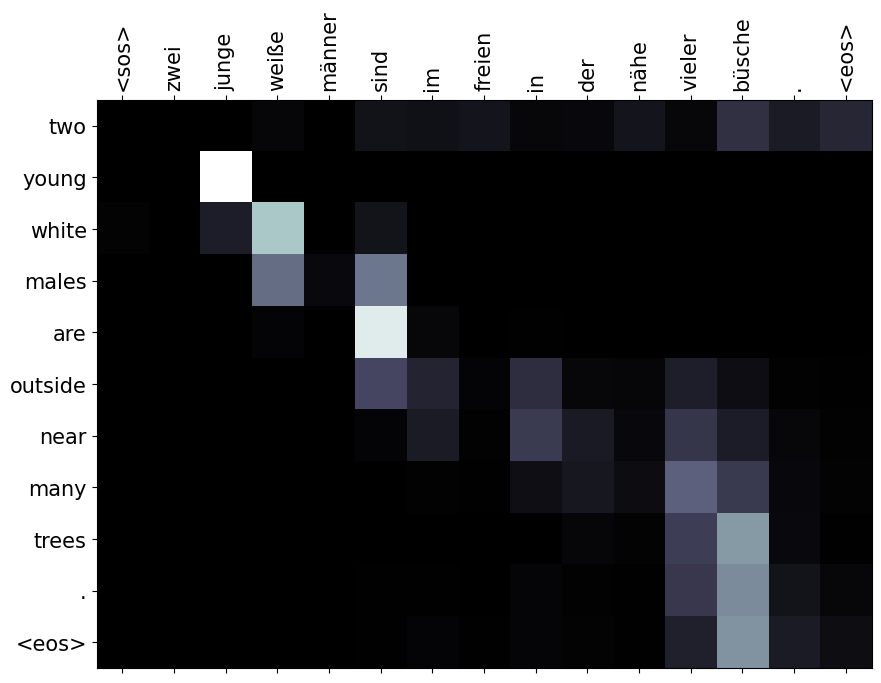

In [ ]:
plot_attention(sentence_tokens, translation, attention)

In [ ]:
# Generate translations for all test examples
# This may take several minutes depending on dataset size and hardware
translations = [
    translate_sentence(
        example["de"],
        model,
        en_vocab,
        de_vocab,
        en_nlp,
        de_nlp,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]

print(f"Generated {len(translations)} translations for test set")

100%|██████████| 1000/1000 [00:15<00:00, 65.96it/s]

Generated 1000 translations for test set


## **9. Quantitative Evaluation with BLEU Score**

### **9.1 BLEU Score Overview**

**BLEU (Bilingual Evaluation Understudy)** is the standard metric for machine translation evaluation:

- **Precision-based metric**: Measures n-gram overlap between predictions and references
- **Range**: 0 (worst) to 1 (perfect match)
- **Interpretation**:
  - BLEU > 0.30: Understandable translations
  - BLEU > 0.40: High-quality translations
  - BLEU > 0.50: Very high-quality, near-human translations

### **9.2 Generate Translations for Test Set**

In [ ]:
# Load BLEU metric from evaluate library
bleu = evaluate.load("bleu")

print(f"BLEU metric loaded successfully")

BLEU metric loaded successfully


### **9.3 Prepare Data for BLEU Computation**

In [ ]:
# Format predictions: remove special tokens and join into strings
predictions = [" ".join(translation[1:-1]) for translation in translations]

# Format references: wrap each reference in a list (BLEU supports multiple references)
references = [[example["en"]] for example in test_data]

print(f"Formatted {len(predictions)} predictions")
print(f"Formatted {len(references)} references")
print(f"\nSample prediction: {predictions[0]}")
print(f"Sample reference: {references[0][0]}")

Formatted 1000 predictions
Formatted 1000 references

Sample prediction: a man in an orange hat is welding something .
Sample reference: A man in an orange hat starring at something.


In [ ]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [ ]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [ ]:
# Compute BLEU score with custom tokenizer
# Using spaCy tokenizer ensures consistent tokenization with training
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

print(f"BLEU Score Results:")
print(f"Overall BLEU: {results['bleu']:.4f}")
print(f"BLEU-1: {results['precisions'][0]:.4f}")
print(f"BLEU-2: {results['precisions'][1]:.4f}")
print(f"BLEU-3: {results['precisions'][2]:.4f}")
print(f"BLEU-4: {results['precisions'][3]:.4f}")

BLEU Score Results:
Overall BLEU: 0.3203
BLEU-1: 0.6327
BLEU-2: 0.3931
BLEU-3: 0.2532
BLEU-4: 0.1672


## **10. Loading Pre-trained Model (Optional)**

This section demonstrates loading a pre-trained model from Google Drive for inference without training.

In [ ]:
import gdown
#https://drive.google.com/file/d/1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd/view?usp=drive_link
gdown.download(id="1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd", output="de2en-model_download.pt")

Downloading...
From (original): https://drive.google.com/uc?id=1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd
From (redirected): https://drive.google.com/uc?id=1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd&confirm=t&uuid=3d54d2dc-16c7-4bea-86f0-5ebafe462bb6
To: /content/de2en-model_download.pt
100%|██████████| 82.1M/82.1M [00:01<00:00, 47.5MB/s]


'de2en-model_download.pt'

In [ ]:
input_dim = 7853
output_dim = 5893
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.6
decoder_dropout = 0.6
n_layers = 2  # Increased number of layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout
)

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
model.load_state_dict(torch.load("de2en-model_download.pt"))

<All keys matched successfully>

In [ ]:
sentence = "Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt"

Translated sentence: a man in an orange hat is welding something .


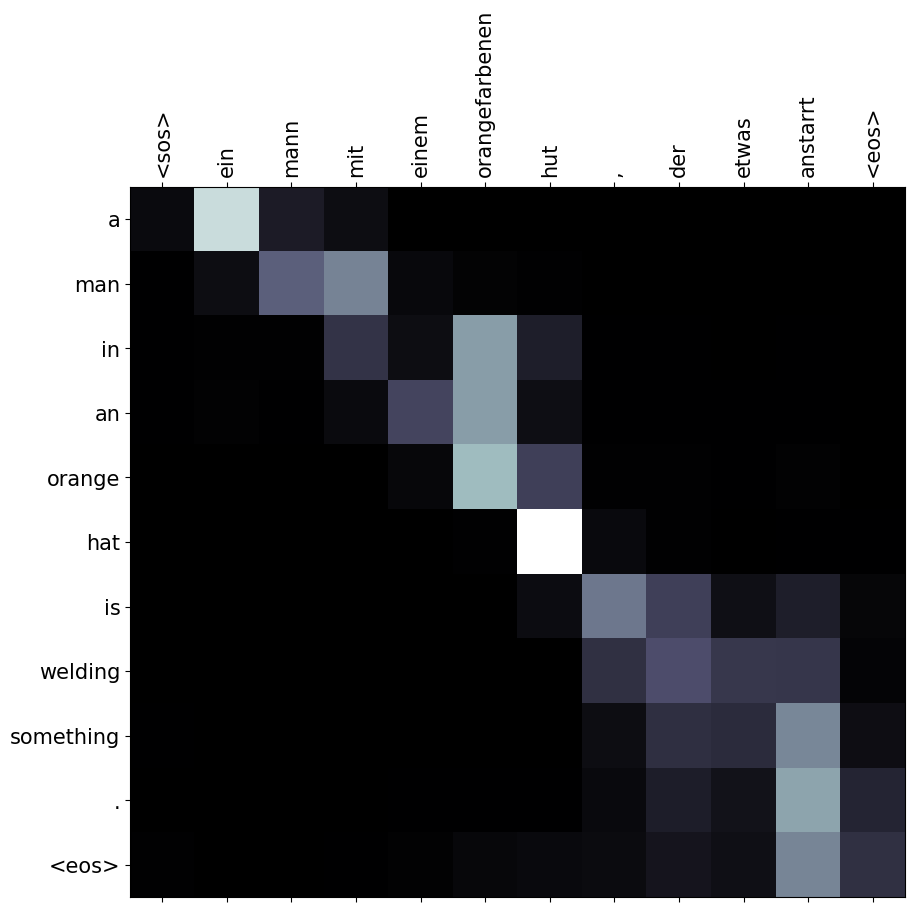

In [ ]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
)
print("Translated sentence:", " ".join(translation[1:-1]))
plot_attention(sentence_tokens, translation, attention)